<a href="https://colab.research.google.com/github/not-sid-29/building-scratch-neural-nets/blob/main/CNNs_from_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from fastai.vision.all import *
matplotlib.rc('image', cmap='Greys')

# Creating Convolutional Neural Networks from scratch:

## 1. Working of Convolutions(computational):

- Convolutions are the heart of operation of any modern day cnn model, it is an operation that does dot product of a filter(which is of smaller size, eg. 3x3) with an input image which is of much larger size, and this operation happens multiple times

- Convolutions operate using a filter, and the filter slides over the input image and calculates dot product<br>
- the filters are called *kernels*

In [ ]:
#Creating a top-edge detection kernel
top_edge = tensor([[-1, -1, -1],
                   [0, 0, 0],
                   [1, 1, 1]]).float()

In [ ]:
data_path = untar_data(URLs.MNIST_SAMPLE)

In [ ]:
Path.BASE_PATH = data_path

<Axes: >

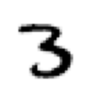

In [ ]:
im3 = Image.open(data_path/'train'/'3'/'12.png')
show_image(im3)

since the `kernel_size=3x3` we will apply the kernel to the top 3x3 edge of the image<br>
> Multiplying each value of the top 3x3 pixels of `im3` with kernel<br>
> Taking a sum of these products

In [ ]:
im3_tensor = tensor(im3)
im3_tensor[0:3, 0:3] * top_edge

tensor([[-0., -0., -0.],
        [0., 0., 0.],
        [0., 0., 0.]])

In [ ]:
(im3_tensor[0:3, 0:3] * top_edge).sum()

tensor(0.)

- the total sum = 0, since most of the top 3x3 pixels of the image is white

In [ ]:
img_df = pd.DataFrame(im3_tensor)
img_df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,12,99,91,142,155,246,182,155,155,155,155,131,52,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,138,254,254,254,254,254,254,254,254,254,254,254,252,210,122,33,0,0,0,0,0,0,0,0,0
7,0,0,0,220,254,254,254,235,189,189,189,189,150,189,205,254,254,254,75,0,0,0,0,0,0,0,0,0
8,0,0,0,35,74,35,35,25,0,0,0,0,0,0,13,224,254,254,153,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,90,254,254,247,53,0,0,0,0,0,0,0,0,0


- The image shows that, colored/black pixels are available in 5th row<br>
- Applying kernel on 3x3 pixels around the black/pixels

In [ ]:
im3_tensor[4:7, 6:9] * top_edge

tensor([[ -0.,  -0.,  -0.],
        [  0.,   0.,   0.],
        [254., 254., 254.]])

In [ ]:
(im3_tensor[4:7, 6:9] * top_edge).sum()

tensor(762.)

***Note***: This calculation shows the presence of top-edges in an given image, the higher the number the more prominent top-edges are seen by the filters

In [ ]:
def apply_kernel(row, col, kernel):
  return (im3_tensor[row-1 : row+2, col-1 : col+2] * kernel).sum()

In [ ]:
apply_kernel(5, 7, top_edge)

tensor(762.)

## 2. Mapping Convolutional Kernels:

<Axes: >

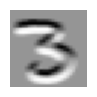

In [ ]:
#Creating a grid of pixels from the image using nested list comprehensions

rng = range(1, 27)
top_pixgrid = tensor([[apply_kernel(i, j, top_edge) for j in rng] for i in rng])

show_image(top_pixgrid)

<Axes: >

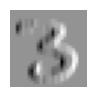

In [ ]:
left_edge = tensor([[-1, 1, 0],
                    [-1, 1, 0],
                    [-1, 1, 0]]).float()

left_edge_img = tensor([[apply_kernel(i, j, left_edge) for j in rng] for i in rng])
show_image(left_edge_img)

## 3. Computational Convolutions(Using PyTorch & FastAi)

*note*:<br>
> a. uptil now, Top Right Edge kernel has been added & Top Left edge kernel has been added,<br>
> b.since PyTorch can apply multiple filters/kernels in one-go, declaring diagonal edge kernels.

In [ ]:
diag1_edge = tensor([[0, -1, 1],
                     [-1, 1, 0],
                     [1, 0, 0]]).float()
diag2_edge = tensor([[1, -1, 0],
                     [0, 1, -1],
                     [0, 0, 1]]).float()
edge_kernels = torch.stack([left_edge, top_edge, diag1_edge, diag2_edge])
edge_kernels.shape

torch.Size([4, 3, 3])

In [ ]:
#Creating a datablock for the data
mnist_db = DataBlock((ImageBlock(cls=PILImageBW), CategoryBlock),
                     get_items = get_image_files,
                     splitter = GrandparentSplitter(),
                     get_y = parent_label)

dls = mnist_db.dataloaders(data_path)
xb, yb = first(dls.valid)
xb.shape


torch.Size([64, 1, 28, 28])

- this is the batch of data containing **64** images, of **1** channel and **28x28** pixel count

In [ ]:
#Fastai by default uses GPU, but for the mathematical part we will shift the calculation to the CPU

xb, yb = to_cpu(xb), to_cpu(yb)

In [ ]:
print(edge_kernels.shape)
#Kernels passed onto pytorch need to be of rank 4

edge_kernels.unsqueeze(1).shape

torch.Size([4, 3, 3])


torch.Size([4, 1, 3, 3])

In [ ]:
edge_kernels = edge_kernels.unsqueeze(1)


batch_features = F.conv2d(xb, edge_kernels)
batch_features.shape

torch.Size([64, 4, 26, 26])

*output note*: 64 Images, 4 kernels, 26x26 pixel size(loss of 1 pixel per side)

<Axes: >

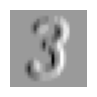

In [ ]:
show_image(batch_features[0, 0])

## Creating a Convolutional Neural Net from scratch:

A simple NN is created as per follows
```
simpleNN = nn.Sequential(
           nn.Linear(28*28, 30),
           nn.ReLU(),
           nn.Linear(30, 1))
```
- So a simple neural  net contains 3 major layers: <br>
- a Linear layer[acts as the Input Layer]<br>
- ReLU layer[Rectified Linear Unit as an activation layer]<br>
- Linear Layer[acts as output layer]




In [ ]:
# A simple CNN:
basic_cnn = nn.Sequential(
    nn.Conv2d(1, 30, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(30, 1, kernel_size=3, padding=1)
)

In [ ]:
basic_cnn

Sequential(
  (0): Conv2d(1, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(30, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [ ]:
#Shape of this linear-looking cnn model
basic_cnn(xb).shape

torch.Size([64, 1, 28, 28])

- this model arch cannot be used for classification, as we need 1 output channel not 28 by 28 map, to fix this, we have to use stride-2 convolution as many times until we reach a single output channel


In [ ]:
def conv(ni, nf, ks=3, act=True):
  """
  A function to create a Convolutional-2D layer
  Parameters:
  ni = Input neurons,
  nf = Output neurons,
  ks = Kernel size,
  act = If activation function will be used or not(default : True)
  """

  res = nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=ks//2)
  if act:
    res = nn.Sequential(res, nn.ReLU())
  return res

In [ ]:
simple_cnn = sequential(              #Activation map size
    conv(1, 4),                       #14x14
    conv(4, 8),                       #7x7
    conv(8, 16),                      #4x4
    conv(16, 32),                     #2x2
    conv(32, 2, act=False),           #1x1 --> o/p layer
    Flatten()
)

In [ ]:
#Creating a learner

learn = Learner(dls, simple_cnn, loss_func=F.cross_entropy, metrics=accuracy)

In [ ]:
learn.summary()

Sequential (Input shape: 64 x 1 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 4 x 14 x 14    
Conv2d                                    40         True      
ReLU                                                           
____________________________________________________________________________
                     64 x 8 x 7 x 7      
Conv2d                                    296        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 16 x 4 x 4     
Conv2d                                    1168       True      
ReLU                                                           
____________________________________________________________________________
                     64 x 32 x 2 x 2     
Conv2d                                    4640       True      
ReLU                                          

In [ ]:
learn.fit_one_cycle(5, 0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.094986,0.055603,0.980373,00:22
1,0.035060,0.025073,0.993621,00:20
2,0.017458,0.017075,0.995093,00:16
3,0.011642,0.011255,0.996075,00:16
4,0.005432,0.009892,0.996565,00:16


### Understanding the layers and trainable parameters of a CNN:

In [ ]:
#The first layer of the simple_cnn model:

first = learn.model[0]
print(first)

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
)


- *Input channels* = 1<br>
- *Output channels* = 4<br>
- *Kernel size* = 3<br>
- *Stride size* = 2<br>
- *Padding* = 1

In [ ]:
#Weight matrix shape:
first[0].weight.shape

torch.Size([4, 1, 3, 3])

- *trainable weights*: 4x1x3x3 = 36, but total trainable params = 40<br>


In [ ]:
#shape of bias:
first[0].bias.shape

torch.Size([4])

## CNN on Colored Images:

In [ ]:
img = image2tensor(Image.open('/content/airplane.jpg'))
img.shape

torch.Size([3, 360, 540])

<Axes: >

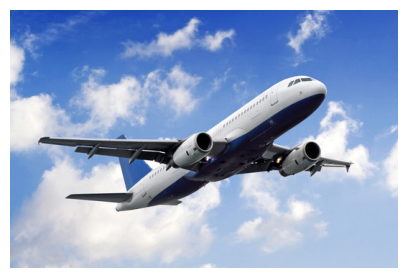

In [ ]:
show_image(img)

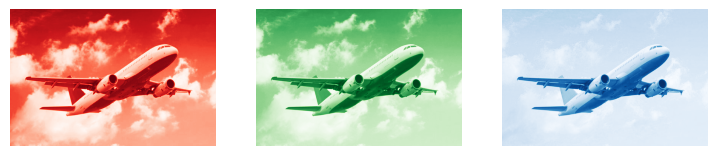

In [ ]:
_, axs = subplots(1, 3)
for im, ax, color in zip(img, axs, ('Reds', 'Greens', 'Blues')):
  show_image(255-im, ax=ax, cmap=color)

<---Refer to Fastai DL book chapter 13 Convolutions--->

### Improving our CNN with training it on the MNIST data:

In [ ]:
path = untar_data(URLs.MNIST)
Path.BASE_PATH = path

In [ ]:
#Listing files:
path.ls()

(#2) [Path('training'),Path('testing')]

In [ ]:
def create_dls(batch=64):
  return DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
      get_items=get_image_files,
      splitter=GrandparentSplitter('training', 'testing'),
      get_y=parent_label,
      batch_tfms=Normalize()
  ).dataloaders(path, bs=batch)


dls = create_dls()




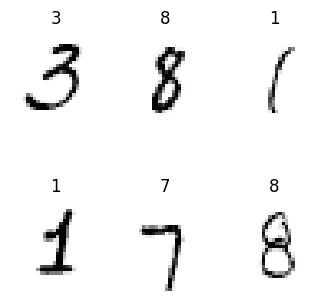

In [ ]:
dls.show_batch(max_n=6, figsize=(4,4))

In [ ]:
def simple_cnn():
  return sequential(
      conv(1,8,ks=5),
      conv(8,16),
      conv(16,32),
      conv(32,64),
      conv(64,10,act=False),
      Flatten()
  )

- To learn about the beahvior of the trainable layers, we can use some type of a callback that records the statistics of the trainable layers

In [ ]:
from fastai.callback.hook import *

### Flash Training the model:

In [ ]:
#training the model

def fit_one_epoch(epoch=1, lr=0.01):
  learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy, metrics=accuracy, cbs=ActivationStats(with_hist=True))
  learn.fit(epoch, lr)
  return learn

In [ ]:
learn = fit_one_epoch(lr=0.06)

/usr/local/lib/python3.10/dist-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,2.305602,2.307739,0.101000,01:42


- The model on higher LR does not perform very well, infact it doesnt train(accuracy=0.10)

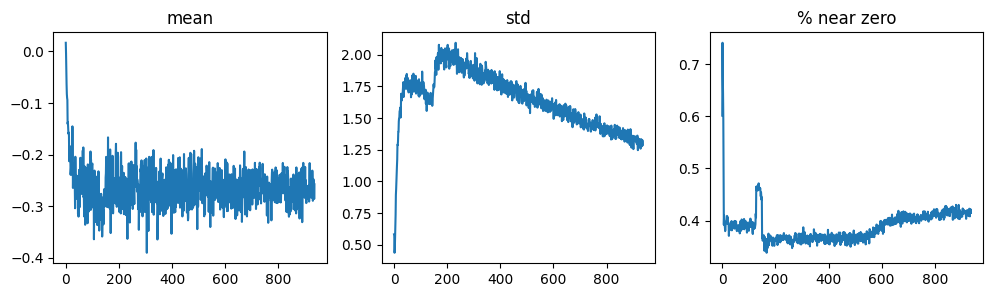

In [ ]:
#Using ActivationStats to understand the behavior of the training:

learn.activation_stats.plot_layer_stats(0)

1. The model training graphs above(mean, std, %near zero) should have been smooth, but we have this inconsistent jagged curve.<br>
2. Checking how the model behaves at the end of the network.

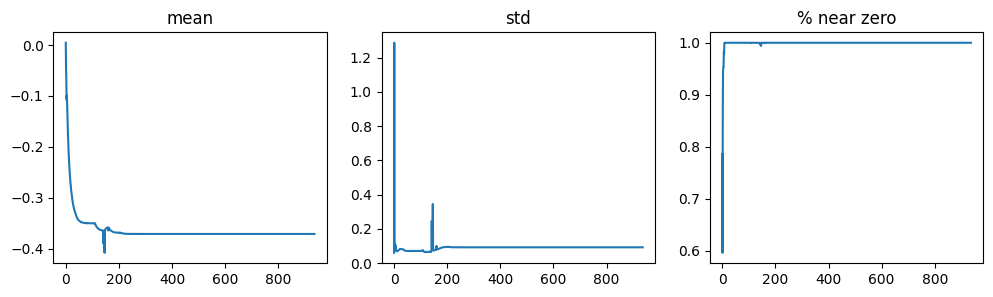

In [ ]:
learn.activation_stats.plot_layer_stats(-2)

- The model does not train at all, since near to no activations happen and the model doesn't learn anything

#### Model training with a very low Learning Rate:

In [ ]:
learn = fit_one_epoch(lr=0.001)

/usr/local/lib/python3.10/dist-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,0.128664,0.111763,0.963700,01:32


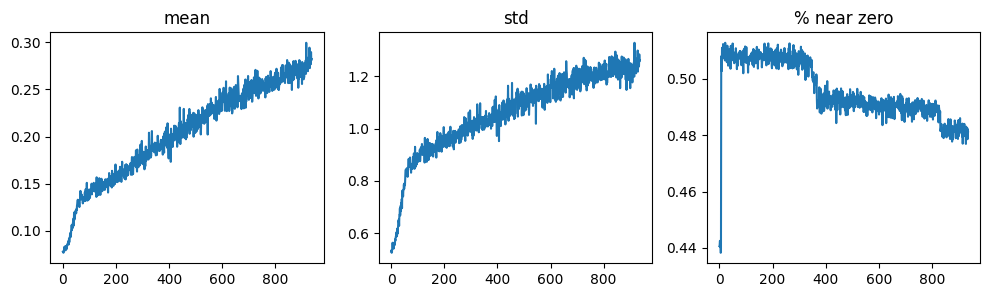

In [ ]:
#Activation Statistics of the first layer:
learn.activation_stats.plot_layer_stats(0)

- This graph shows that, the model has a very smooth curve starting from the first layer

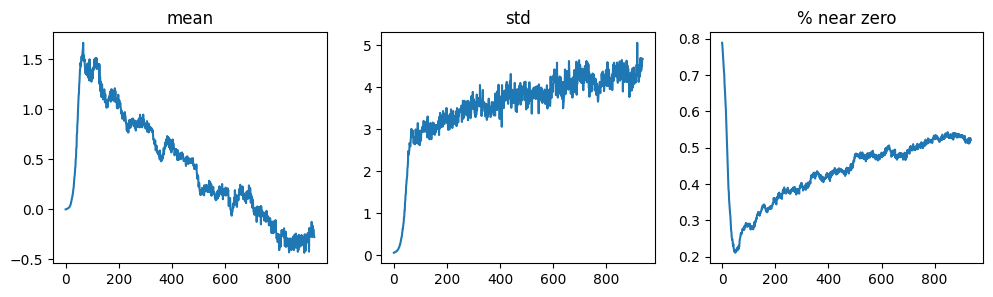

In [ ]:
#last layer activation stats:
learn.activation_stats.plot_layer_stats(-2)

- This shows that we see maximum activations as well

#### Improving the training of the model:

a. Increasing batch size

In [ ]:
inc_dls = create_dls(512)

In [ ]:
learn = fit_one_epoch(lr=0.06)

/usr/local/lib/python3.10/dist-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,2.307378,2.305492,0.100900,01:59


- Increasing the batch size does not help the model training at all,<br>
> *prev. batch size* = 64, *prev. accuracy*=0.101;<br>
> *curr. batch size* = 512, *curr. accuracy*=0.100;

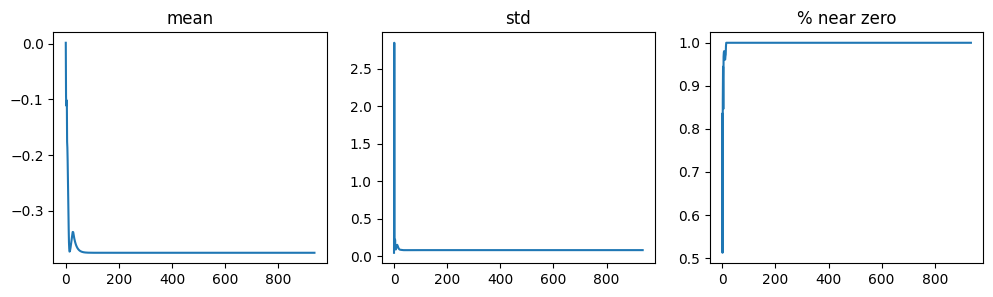

In [ ]:
learn.activation_stats.plot_layer_stats(-2) #last layer statistics

- This case is worser than our previous iteration

b. 1cycle Training:

In [ ]:
def fit_1_cycle(epochs=1, lr=0.06):
  learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy, metrics=accuracy, cbs=ActivationStats(with_hist=True))
  learn.fit_one_cycle(epochs, lr)
  return learn

In [ ]:
learn = fit_1_cycle()

/usr/local/lib/python3.10/dist-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,0.148352,0.116778,0.965500,01:41


- The accuracy from the past 3 iterations where LR=0.06, this case has the highest accuracy,<br>
> case1: *accuracy*=0.101(batch_size=64, LR=0.06)<br>
> case2: *accuracy*=0.100(batch_size=512, LR=0.06)<br>
> case3: *accuracy*=0.965(batch_size=512, LR=0.06, 1cycle Training)

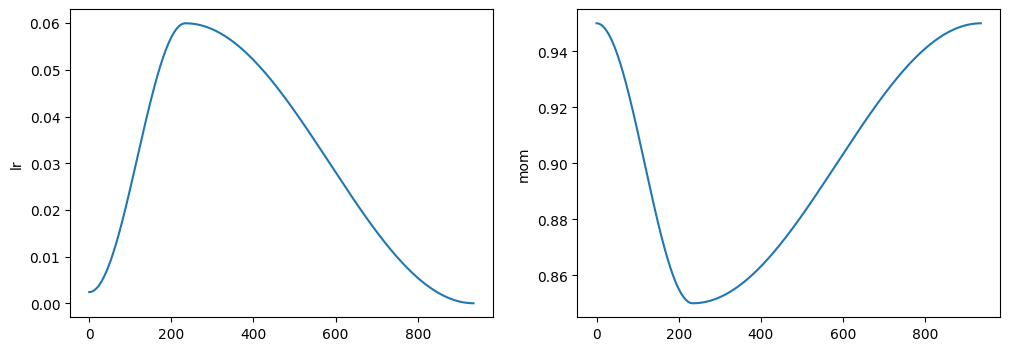

In [ ]:
#Plotting the learning & momentum of the modeul during training:
learn.recorder.plot_sched()

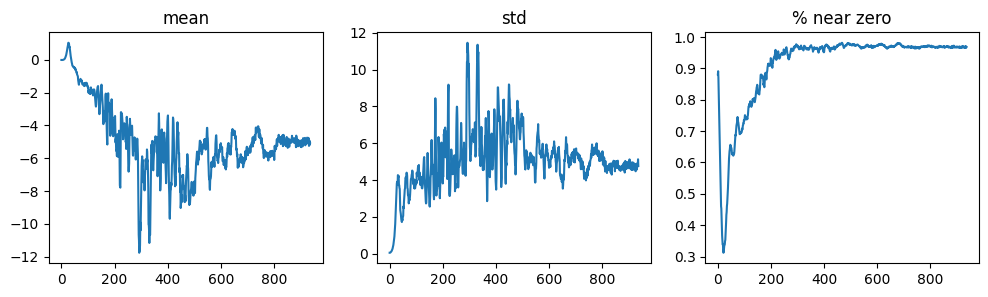

In [ ]:
learn.activation_stats.plot_layer_stats(-2)

- The % near zero(pct. of near zero weights) are still high for the last layer

**Visualizing using Colored Histogram**

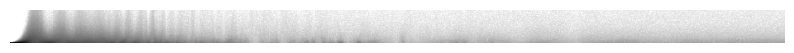

In [ ]:
learn.activation_stats.color_dim(-2)

- This Activation chart shows that at start nearly all weights are 0, this condition is a case of "Bad/Unhealthy Training"

c. Fixing the bad training using **Batch Normalization**:

* BATCH NORMALIZATION:  works by taking the average of the mean and standard deviations of a network and then using that to normalize the activations(this norm happens per mini-batch)

In [ ]:
#adding a batchnorm layer to the conv model:

def conv(ni, nf, ks=3, act=True):
  layers = [nn.Conv2d(ni, nf, kernel_size=ks, stride=2, padding=ks//2)]
  if act:
    layers.append(nn.ReLU())
  layers.append(nn.BatchNorm2d(nf))
  return nn.Sequential(*layers)

In [ ]:
learn = fit_1_cycle()

/usr/local/lib/python3.10/dist-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,0.059877,0.038922,0.988000,01:44


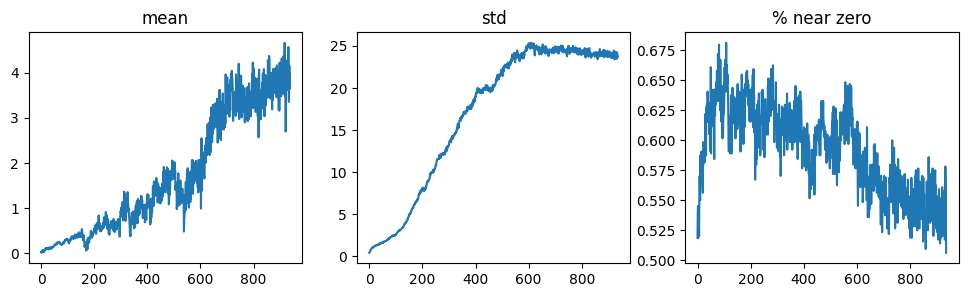

In [ ]:
learn.activation_stats.plot_layer_stats(-2)

- This time, the pct of near-zero weights are nowhere

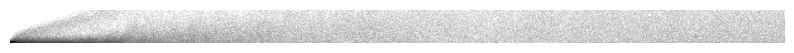

In [ ]:
#Using colored histogram map

learn.activation_stats.color_dim(-2, figsize=(10, 10))

- a smooth learning curve with no sharp jumps or falls

- **Training the model at higher learning rates for more number of epochs**:

In [ ]:
learn = fit_1_cycle(epochs=6, lr=0.1)

/usr/local/lib/python3.10/dist-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,0.144610,0.096819,0.970800,01:52
1,0.102171,0.071983,0.978300,01:41
2,0.076594,0.073612,0.976700,01:41
3,0.056679,0.045652,0.986300,01:40
4,0.031295,0.025886,0.992000,01:41
5,0.014713,0.021111,0.993300,01:41
